In [12]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [8]:
theta = 0 # all pixels black
qc = QuantumCircuit(3)


qc.h(0)
qc.h(1)

qc.barrier()
#Pixel 1

qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.barrier()
#Pixel 2

qc.x(1)
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.barrier()

qc.x(1)
qc.x(0)
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)


qc.barrier()

qc.x(1)

qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.measure_all()

print(qc)

        ┌───┐ ░                                       ░                    »
   q_0: ┤ H ├─░─────■──────■─────────────■────────────░──────────■──────■──»
        ├───┤ ░     │    ┌─┴─┐         ┌─┴─┐          ░ ┌───┐    │    ┌─┴─┐»
   q_1: ┤ H ├─░─────┼────┤ X ├────■────┤ X ├────■─────░─┤ X ├────┼────┤ X ├»
        └───┘ ░ ┌───┴───┐└───┘┌───┴───┐└───┘┌───┴───┐ ░ └───┘┌───┴───┐└───┘»
   q_2: ──────░─┤ Ry(0) ├─────┤ Ry(0) ├─────┤ Ry(0) ├─░──────┤ Ry(0) ├─────»
              ░ └───────┘     └───────┘     └───────┘ ░      └───────┘     »
meas: 3/═══════════════════════════════════════════════════════════════════»
                                                                           »
«                                ░ ┌───┐                                     »
«   q_0: ───────────■────────────░─┤ X ├────■──────■─────────────■───────────»
«                 ┌─┴─┐          ░ ├───┤    │    ┌─┴─┐         ┌─┴─┐         »
«   q_1: ────■────┤ X ├────■─────░─┤ X ├────┼────┤ X ├────■────┤ X ├──

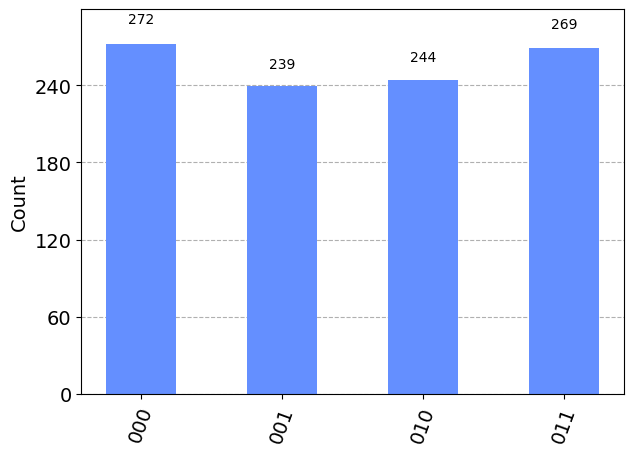

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend = backend, shots = 1024)

results = job.result()
plot_histogram(results.get_counts(qc))

In [14]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

/tmp/ipykernel_62/2428515937.py:6: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


least busy backend:  ibmq_quito


In [15]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


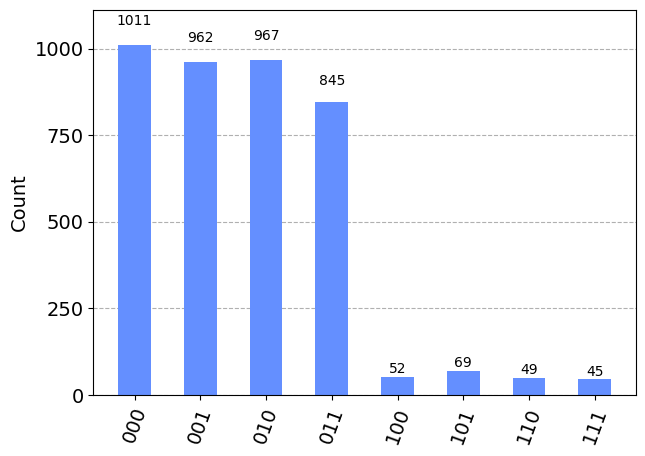

In [16]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

In [18]:
print("Depth : ", qc.depth())
print("Operations: ", qc.count_ops())

Depth :  23
Operations:  OrderedDict([('cry', 12), ('cx', 8), ('barrier', 5), ('x', 4), ('measure', 3), ('h', 2)])


In [19]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc)
print(new_circ)

        ┌─────────────┐ ░                                                  »
   q_0: ┤ U3(π/2,0,π) ├─░────────────────■─────────────────■────────■──────»
        ├─────────────┤ ░                │                 │      ┌─┴─┐    »
   q_1: ┤ U3(π/2,0,π) ├─░────────────────┼─────────────────┼──────┤ X ├────»
        └─────────────┘ ░ ┌───────────┐┌─┴─┐┌───────────┐┌─┴─┐┌───┴───┴───┐»
   q_2: ────────────────░─┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├┤ X ├┤ U3(0,0,0) ├»
                        ░ └───────────┘└───┘└───────────┘└───┘└───────────┘»
meas: 3/═══════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                    ░ »
«   q_0: ─────────────────────────────■──────────────────────────────░─»
«                                   ┌─┴─┐                            ░ »
«   q_1: ──■─────────────────■──────┤ X ├──────■─────────────────■───░─»
«        ┌─┴─┐┌

In [20]:
print("Depth : ", new_circ.depth())
print("Operations: ", new_circ.count_ops())

Depth :  50
Operations:  OrderedDict([('cx', 32), ('u3', 30), ('barrier', 5), ('measure', 3)])
